# Notes for us:

Paper source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5009332/

Data source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5009332/bin/srep32586-s2.xls

Paper for original analysis:

https://osf.io/wzhe7/

https://bmcplantbiol.biomedcentral.com/articles/10.1186/s12870-019-2039-9


Goals for us:

Compare normal regression to the quantile regression stuff from the paper and critically analyse.

Secondly, obviously these metrics will have interaction terms, and salt may affect 1 and only indirectly the other. For example, there may be a plausible connect between flowering time and ear number per plant. These may both be directly infleunced by an overall salt-tolerance factor, as well as each other. 

Structured equation modelling (SEM) allows us to model these correlations and define a general "salt-tolerance" factor. 

Theoretically, we can then use this factor to compare plant strains to see if any are more or less salt tolerant. Sample sizes we strain are relatively small, which is common in plant sciences, which allows for good critical discussion about the limitations of statistical inference. 

From here, if this is done in time, we can then include bayesian modelling to see if the observed data sufficiently updates our priors (control data + assumptions) to the point of significance. 




# Intro

Why salt tolerance? Climate change, feeding people. Allows for testing plant genetics and development of salt resistance crops.

Flowering time (HEA), maturity time (MAT), ripening period (RIP), plant height (HEI), thousand grain mass (TGW), ear number per plant (EAR), grain number per ear (GPE), dry mass per m2 (DRY_WT), yield (YLD), and harvest index (HI).

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm

%config InlineBackend.figure_format = "retina"

from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer
import semopy

In [445]:
data = pd.read_excel("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5009332/bin/srep32586-s2.xls",skiprows=1)
color = ["Yellow" if x == "Control" else "Blue" for x in data["Condition"]]

In [446]:
data.head()

Year Condition    Line  HEA (days)  MAT (days)  RIP (days)   HEI (cm)  \
0  2013   Control  116/2A   78.971743  105.874457   26.902714  81.199163   
1  2014   Control  116/2A   81.269630  107.978607   26.708977  94.311842   
2  2013    Saline  116/2A   79.437118  104.126136   24.689019  60.214062   
3  2014    Saline  116/2A   82.096867  108.555369   26.458502  66.768727   
4  2013   Control   58/1A   84.718291  111.072920   26.354628  80.871357   

     TGW (g)       EAR        GPE  DRY_WT (g.m-2)  YLD (g.m-2)        HI  
0  28.774010  3.520040  38.209917      595.578102   255.682736  0.429302  
1  29.592105  5.601958  30.665407      684.218510   227.257922  0.332142  
2  26.175418  2.105209  28.484131      496.715091   167.680495  0.337579  
3  26.116034  4.506042  18.119211      631.278053   128.758535  0.203965  
4  26.989190  3.536910  37.389277      508.751277   211.371897  0.415472

#### General scatter matrix

We see that on an overall level, correlations are relatively non-existant. However, once we break the data down into groups (Treatment, Year), the correlations become much more apparent.

We exploit this structure to define an overall "salt-tolerance" factor. Finally we compare the correlation of the Salt tolerance factor to the Salt tolerance index used in the publication.

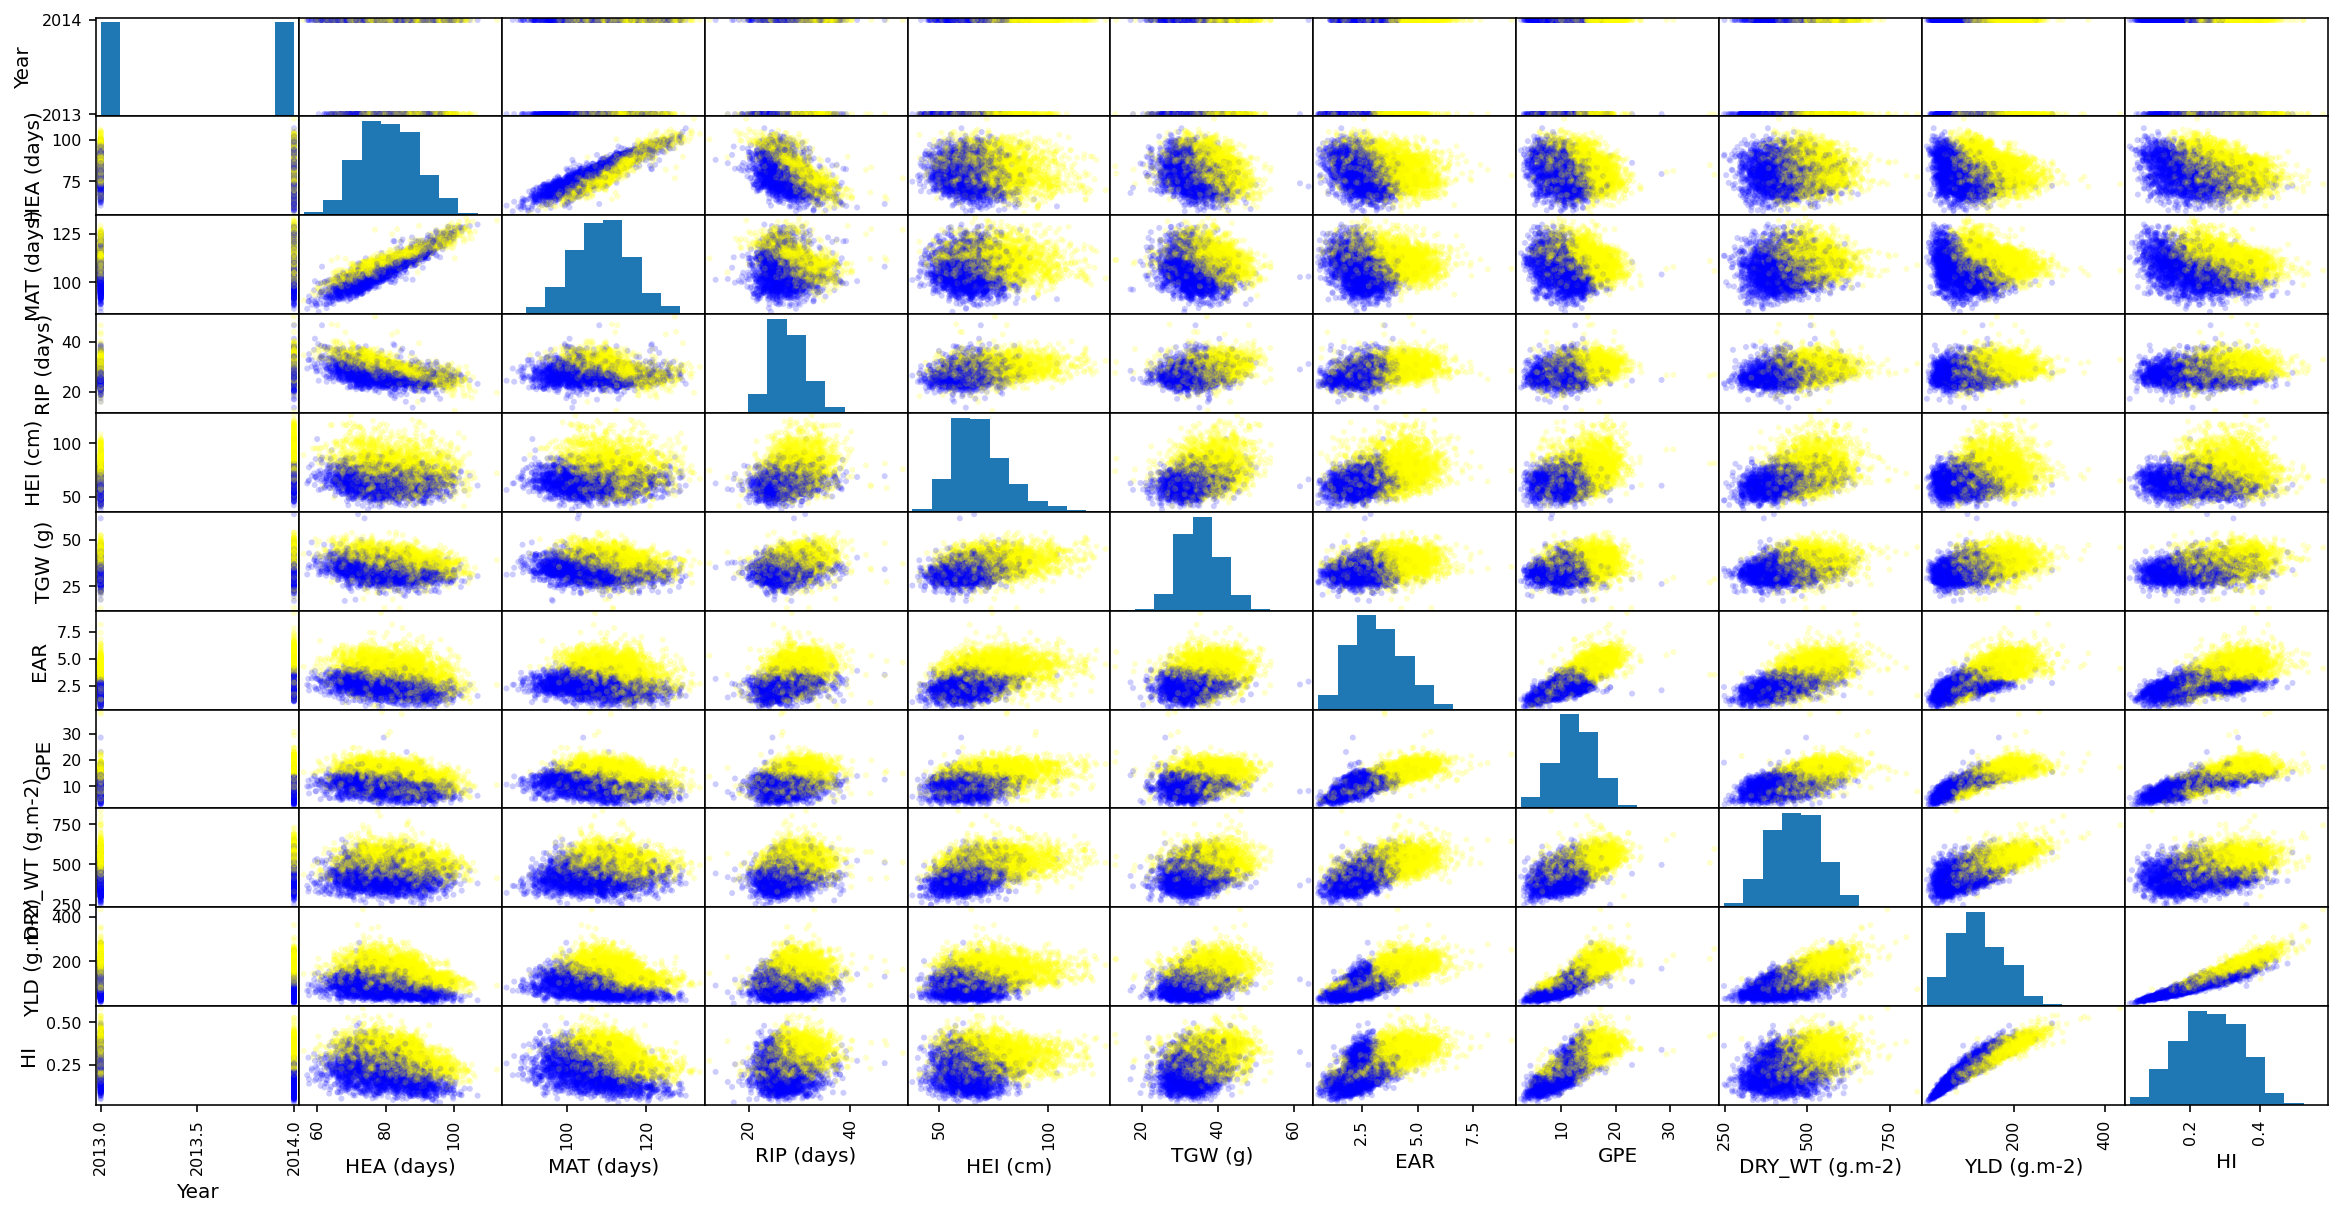

In [255]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20,10), c=color);

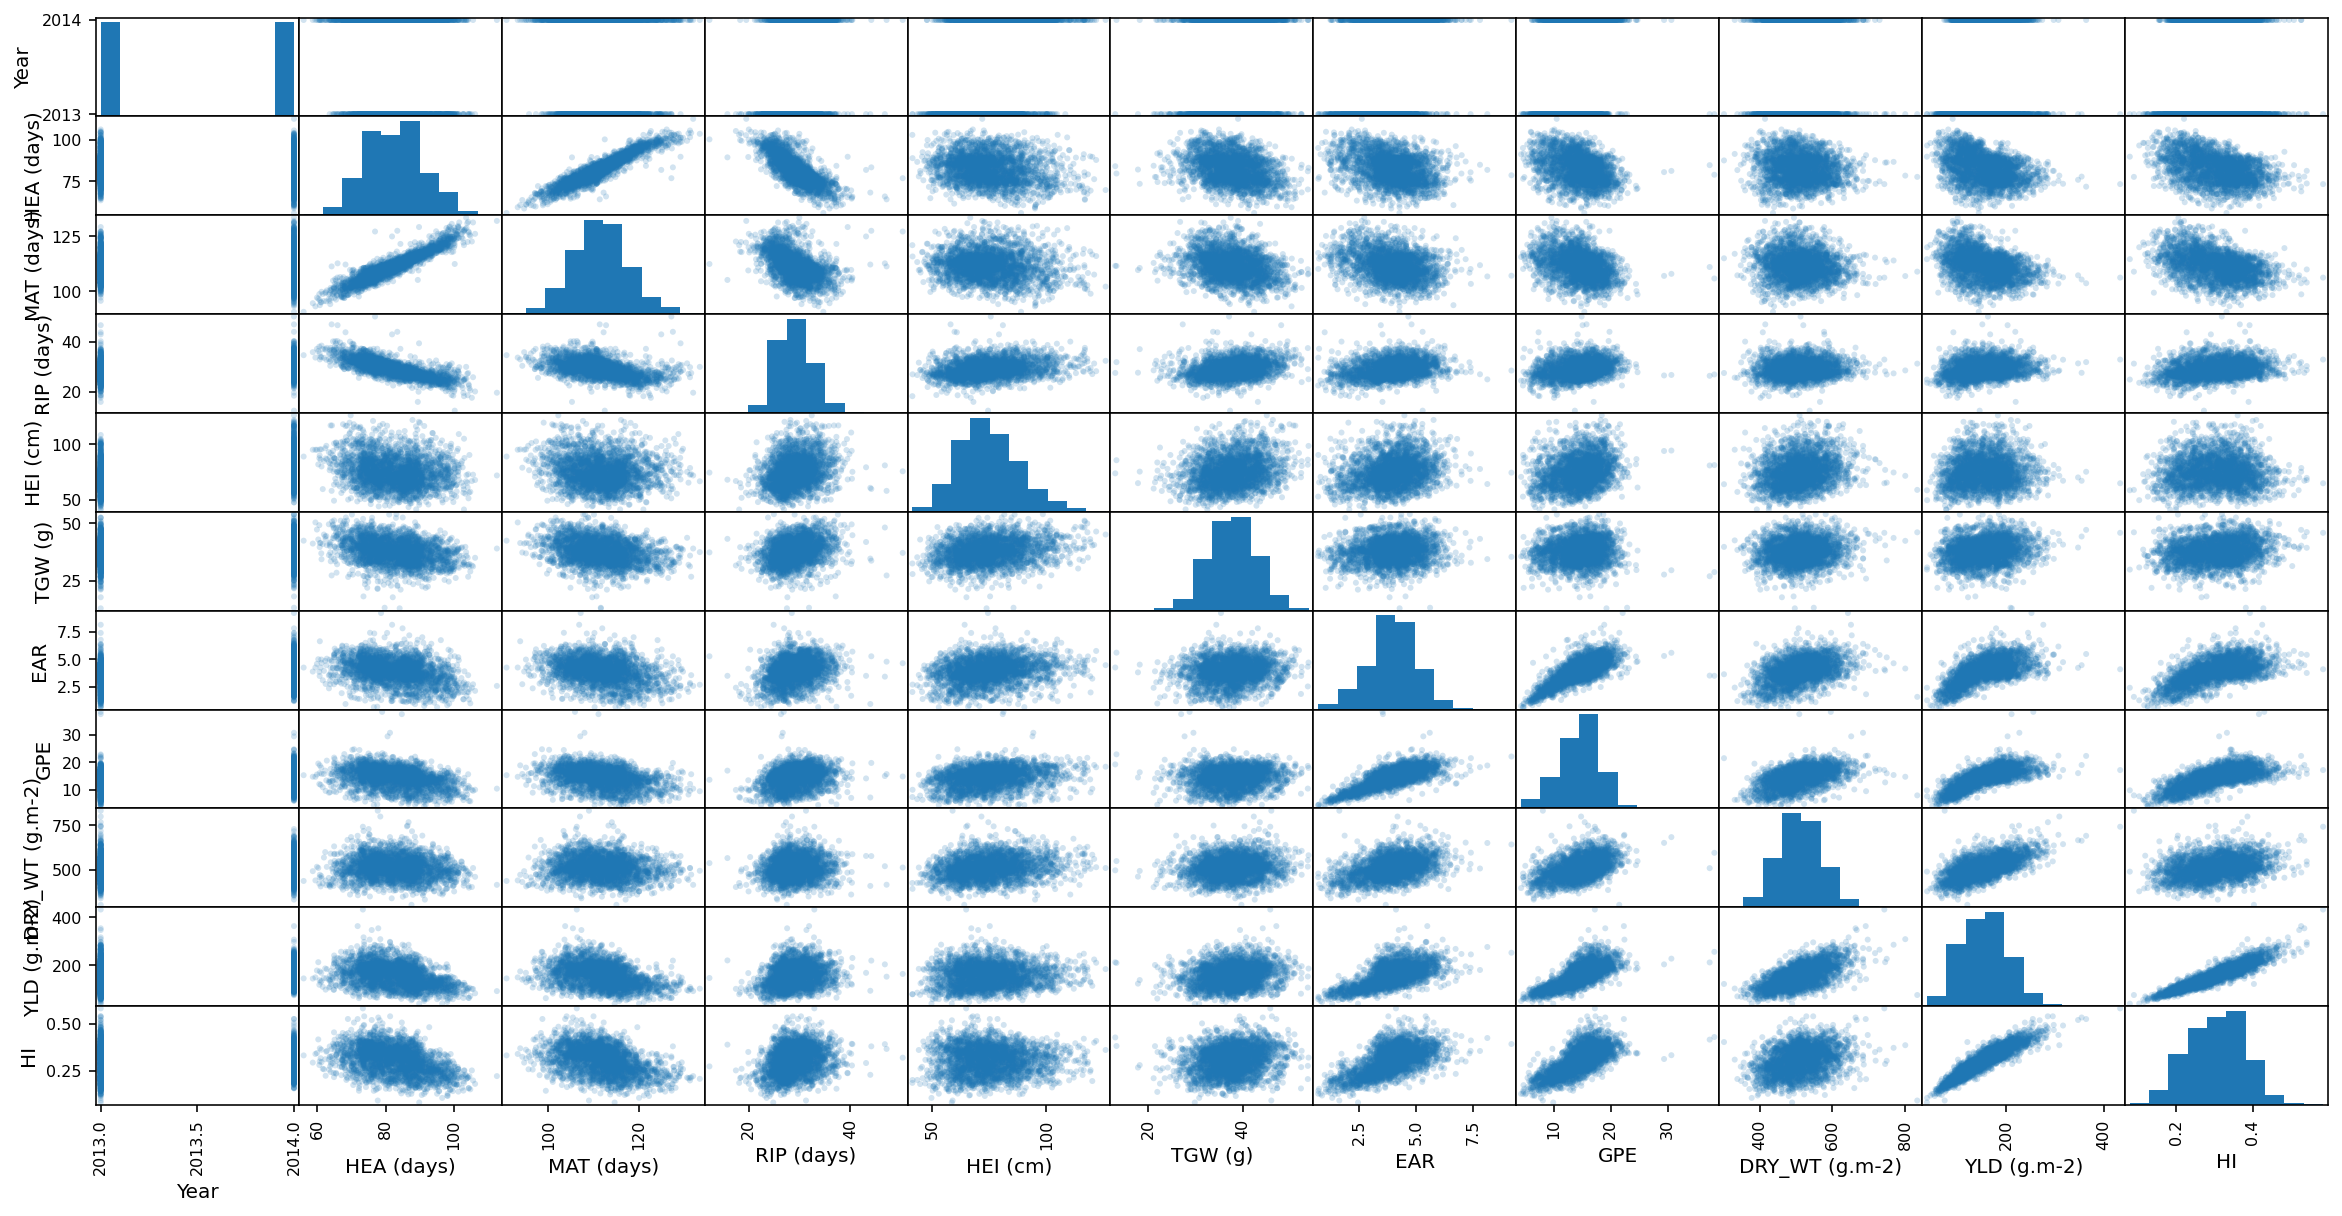

In [259]:
pd.plotting.scatter_matrix(data[data["Condition"]=="Control"], alpha=0.2, figsize=(20,10));

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 2014.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 2014.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 2014.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])


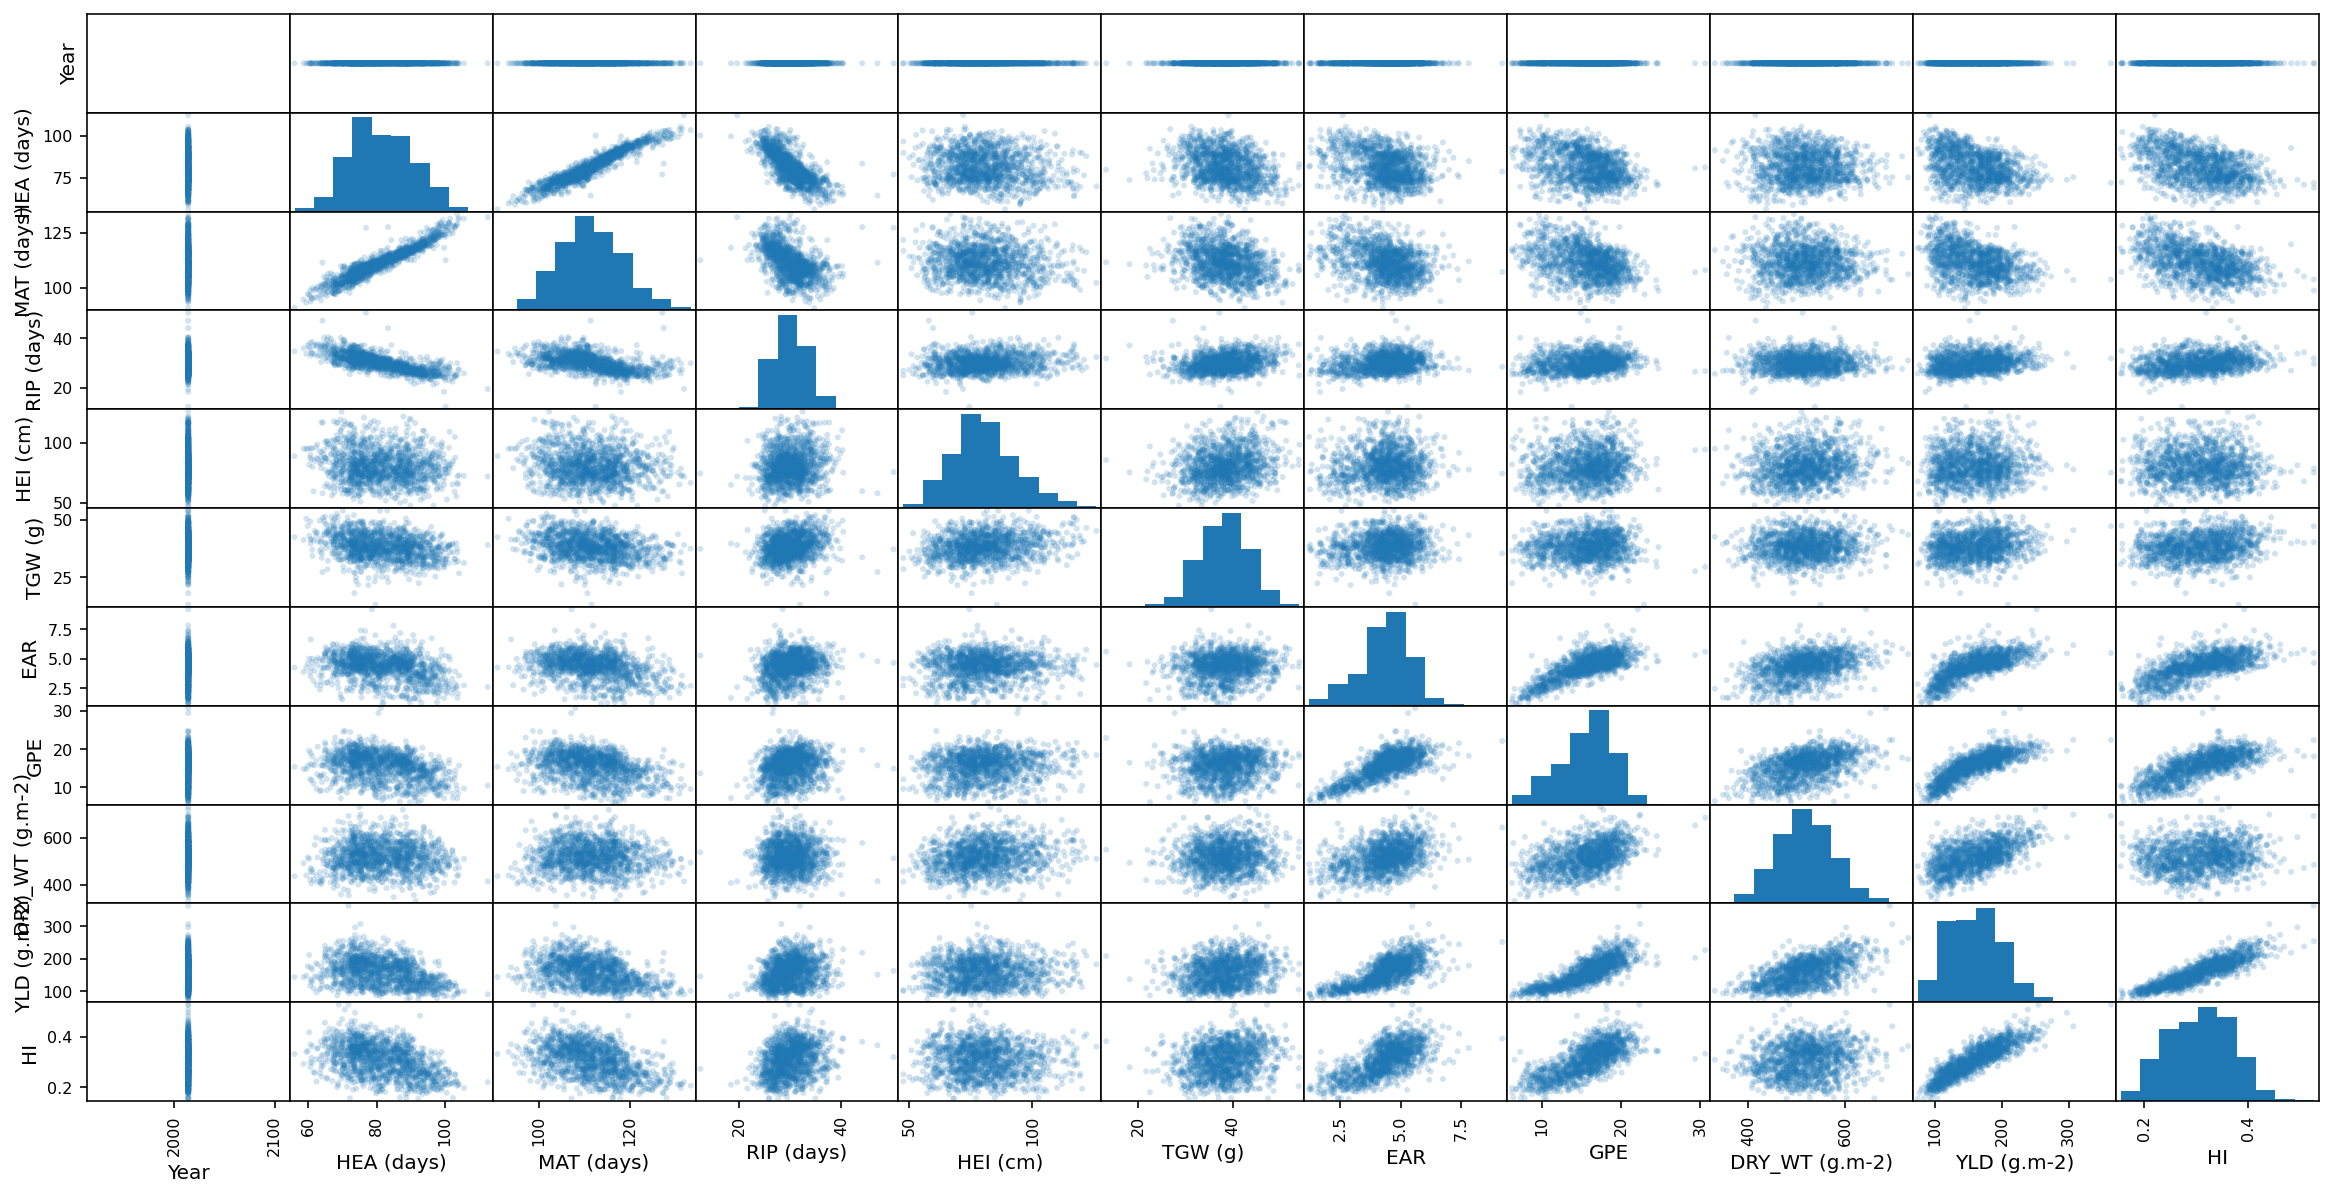

In [450]:
pd.plotting.scatter_matrix(data[(data["Condition"]=="Control") & (data["Year"]==2014)], alpha=0.2, figsize=(20,10));

### Pre-processing.

We want to model the response to the salt treatment, and see how each variable responds to the change. To do this, we essentially ask "How much do you change with when we add salt". Inline with the original authors, and to produce a variable that is on the same scale as the original salt tolerance factor, we divide the treatment group by the square root of the control group.

The dataframe below is the result:

In [451]:
dt = data.groupby(["Line","Year","Condition"]).mean()     .reset_index()
dt_c = dt[dt["Condition"]== "Control"].loc[:,dt.columns != 'Condition'].groupby(["Line","Year"]).mean()
dt_t = dt[dt["Condition"]!= "Control"].loc[:,dt.columns != 'Condition'].groupby(["Line","Year"]).mean()

# Center
#dt_t = dt_t-dt_t.mean()
#dt_c = dt_c-dt_c.mean()

df = dt_t / np.sqrt(dt_c)
dt_c.columns = [s[0:3].strip() for s in list(df.columns)]
dt_t.columns = [s[0:3].strip() for s in list(df.columns)]
df.columns = [s[0:3].strip() for s in list(df.columns)]

ST_1 = dt_t["YLD"] / np.sqrt(dt_c["YLD"])

In [452]:
df

HEA        MAT       RIP       HEI       TGW       EAR  \
Line       Year                                                                
116/2A     2013  8.938973  10.119619  4.759987  6.682241  4.879703  1.122074   
           2014  9.106730  10.446780  5.119607  6.875274  4.800863  1.903817   
58/1A      2013  9.357080  10.486638  4.751942  6.547840  5.506908  0.957168   
           2014  9.447640  10.704132  5.042506  6.735900  5.461646  1.823897   
Barke      2013  8.513550   9.734986  4.727403  7.551173  5.559241  1.367419   
...                   ...        ...       ...       ...       ...       ...   
HEB_25_143 2014  9.718613  10.978678  5.110600  7.401811  5.455157  1.216234   
HEB_25_152 2013  8.198878   9.512314  4.844085  7.855237  5.768169  1.155471   
           2014  8.064902   9.559328  5.139758  8.092126  5.765412  1.112892   
HEB_25_156 2013  8.360327   9.719099  4.960278  6.378418  5.604504  1.498349   
           2014  8.016470   9.648517  5.380563  6.560529  5.596869  1.308298   

                      GPE        DRY        YLD        HI  
Line       Year                                            
116/2A     2013  4.608026  20.353448  10.486531  0.515221  
           2014  3.272012  24.133665   8.541153  0.353910  
58/1A      2013  3.767774  19.581098   7.532352  0.384675  
           2014  2.886781  23.743287   8.384914  0.353149  
Barke      2013  3.693752  19.642187  11.046557  0.562389  
...                   ...        ...        ...       ...  
HEB_25_143 2014  2.171099  20.253139   5.114593  0.252533  
HEB_25_152 2013  2.342103  16.400953   4.850711  0.295758  
           2014  1.843551  18.271314   3.324378  0.181945  
HEB_25_156 2013  2.216951  16.704765   5.803886  0.347439  
           2014  1.983739  18.561018   4.164604  0.224374  

[2680 rows x 10 columns]

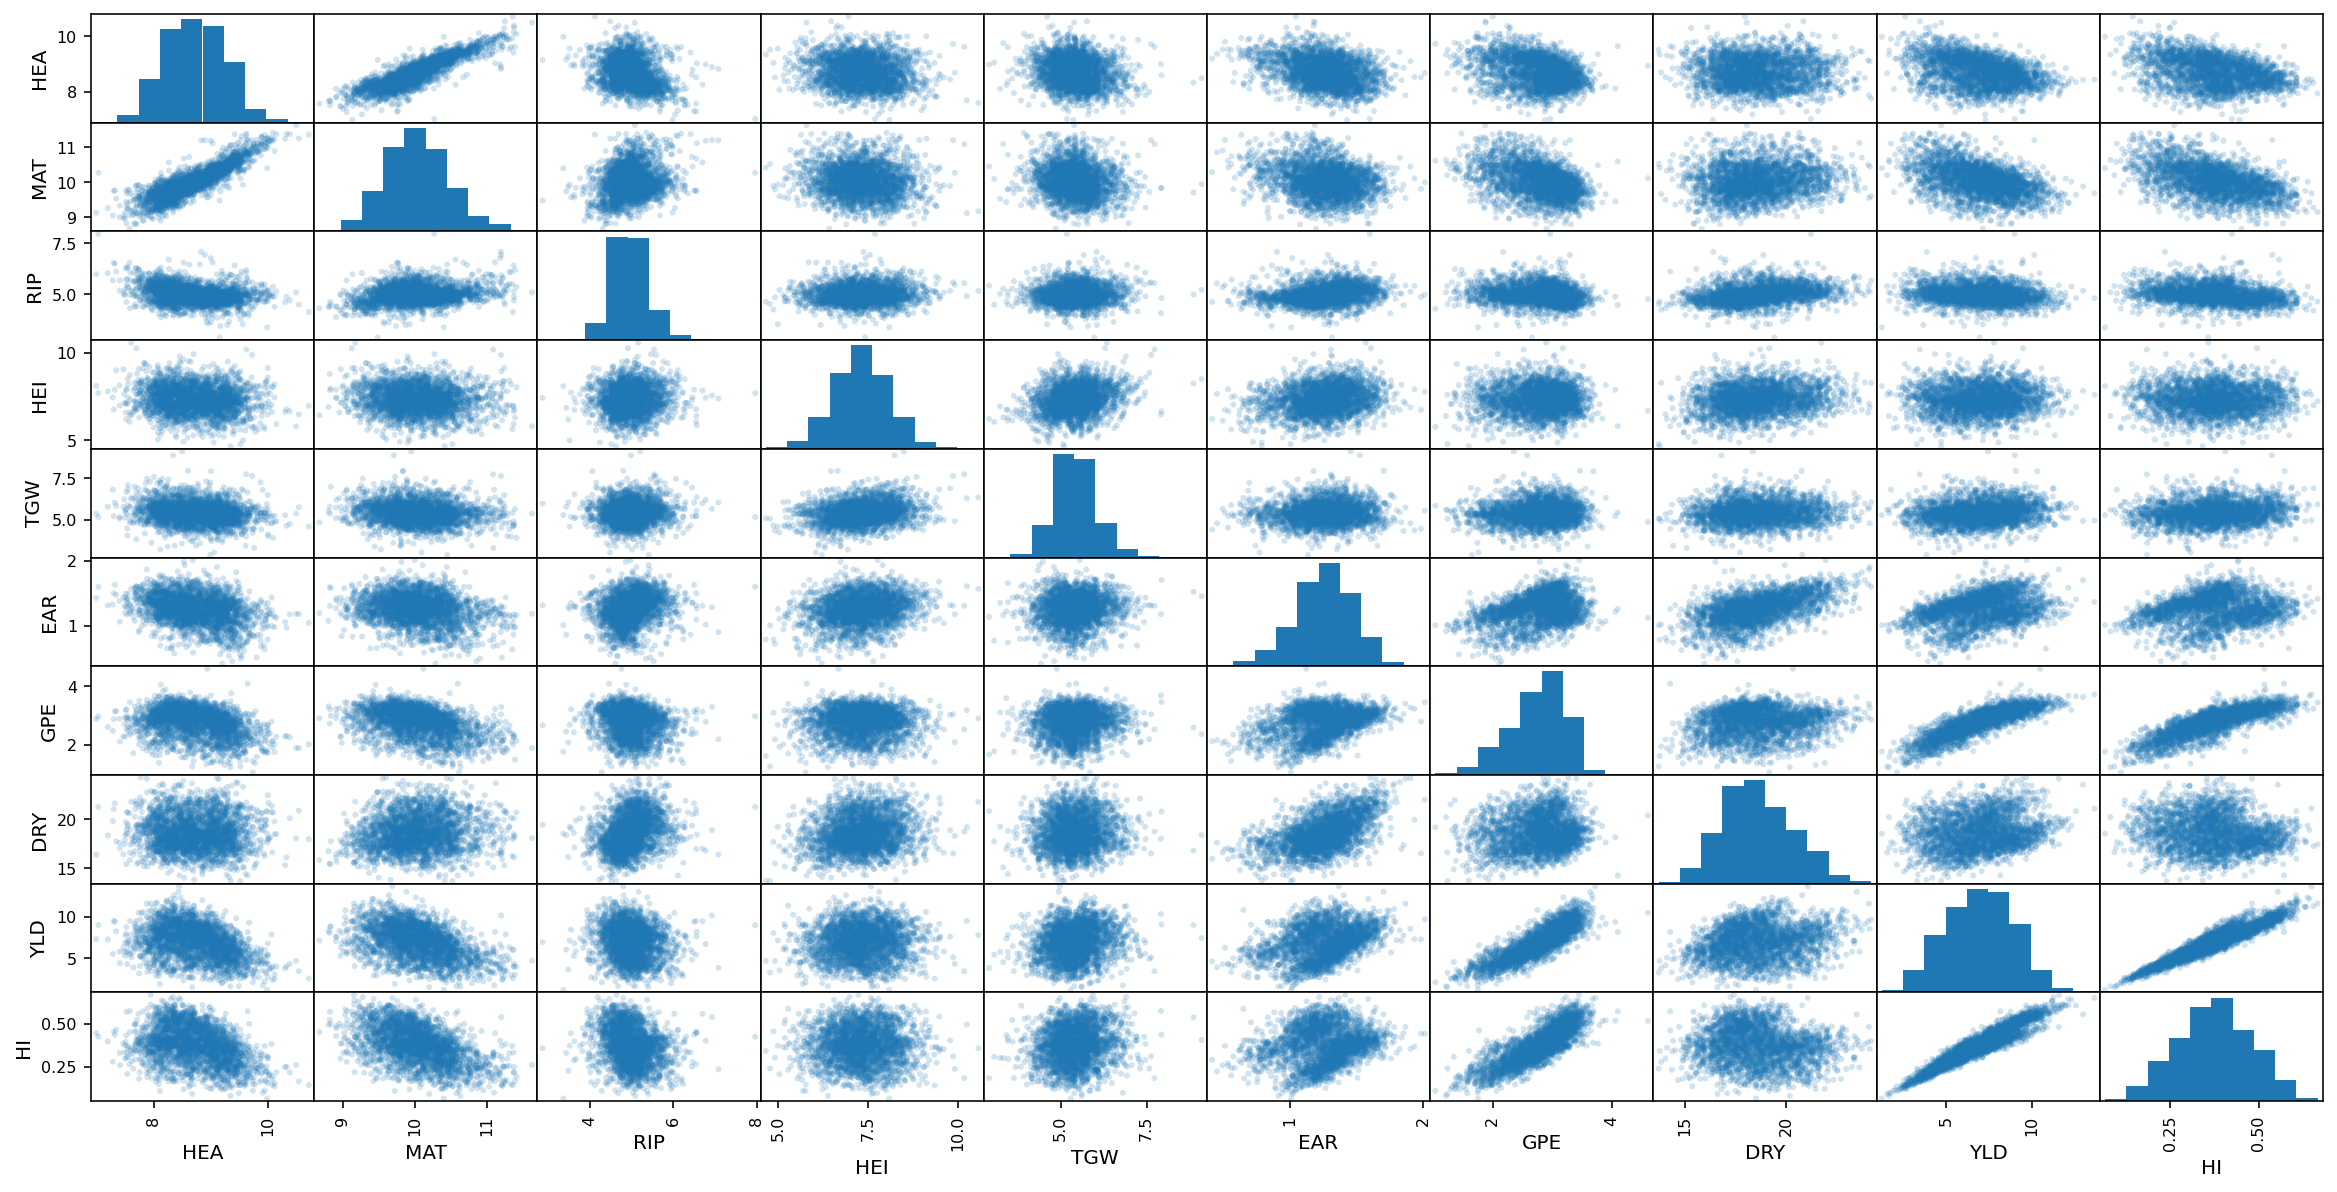

In [453]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20,10));

### Run Linear regression and interpret

- Use Statsmodels for the interpretation

### Fit a Quantile Regression and interpret
- Why did they use quantile regression in the paper?
- Perhaps the data are heteroskedastic, meaning we quantiles change across treatment. We can check this with some plots.

## Next part:

Above, we used the $\frac{y_t}{sqrt(y_c)}$ as an index for salt tolerance (as suggested by the paper(s)).
This index is obviously heavily dependent on yield, and is in essence a proxy for salt tolerance, it only considers the yield of the plant.

Outside of food production, it can be beneficial if the plant grows faster, is thicker, produces more cholorophil and so forth. The dataset we have available to us, was curated with the purpose of testing salt tolerance. Despite the author's choice of salt tolerance index, there are still some general plant statistics that are not directly related to yield.

We make some assumptions: primarily, that "more is better". Under these assumptions, is it possible to define a multi-dimensional measure of plant health and/or salt tolerance?

We can model plant health based on the control plants. We can then apply this model to the treatment plants to get a measure for their plant health?

#### Run PCA/Other factor models and interpret the structure
- How many factors do we have?
- What is the factor structure?

The below PCA suggests only a single factor. At most, maybe 2. This is in line with "plant health" and or "salt tolerance" being a relatively simple construct.


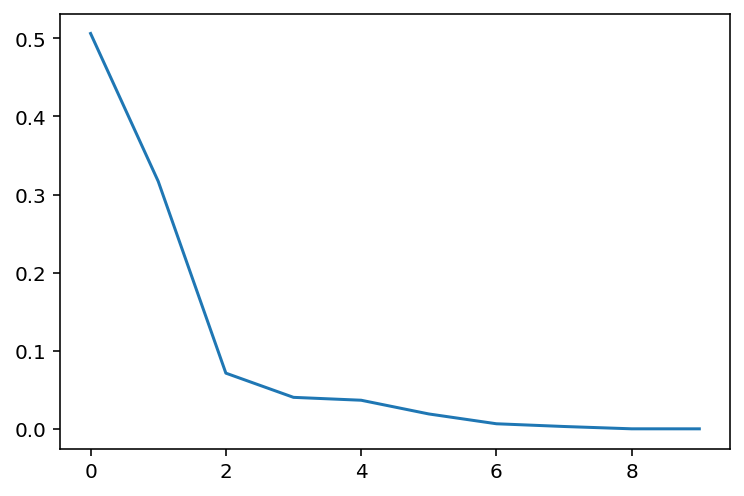

In [460]:
pca = PCA()
pca.fit(df.values)
plt.plot(pca.explained_variance_ratio_);

# Recheck the criteria of factor selection. Looks like we have at most 2 main factor.
# Makes sense, as the dataset is supposed to measure Salt Tolerence.

In [461]:
fa = FactorAnalyzer(n_factors=4,rotation="varimax")
fa.fit(df)
df_loadings = pd.DataFrame(fa.loadings_, index=df.columns)
(abs(df_loadings)>0.7)*df_loadings
df_loadings


0         1         2         3
HEA -0.191090  0.936321 -0.143995 -0.242271
MAT -0.269963  0.930268 -0.040689  0.234435
RIP -0.151476 -0.052839  0.215571  0.961025
HEI -0.012606 -0.115114  0.251703  0.020315
TGW  0.097896 -0.141813  0.104097  0.041388
EAR  0.219438 -0.171499  0.669842  0.091673
GPE  0.826931 -0.161358  0.173558 -0.077144
DRY  0.037087  0.135778  0.821657  0.127399
YLD  0.954079 -0.184108  0.202220 -0.053226
HI   0.960797 -0.239267 -0.124674 -0.087792

### Fit SEM model(s)
- Are there subfactors?
- Is there just one overall factor (in essence linear regression)



##### Notes:

- RIP fucks everything up. Looks like it has no relation to the rest.
- Growth and Yield factors have no real relationship.

Flowering time (HEA), maturity time (MAT), ripening period (RIP), plant height (HEI), thousand grain mass (TGW), ear number per plant (EAR), grain number per ear (GPE), dry mass per m2 (DRY_WT), yield (YLD), and harvest index (HI).

In [300]:
dt_c.loc[:,2013,:]

HEA         MAT        RIP        HEI        TGW  \
Line       Year                                                           
116/2A     2013  78.971743  105.874457  26.902714  81.199163  28.774010   
58/1A      2013  84.718291  111.072920  26.354628  80.871357  26.989190   
Barke      2013  82.201541  110.657415  28.455874  69.489713  39.756973   
CM72       2013  87.542196  115.034586  27.492389  63.964991  39.753071   
HEB_01_001 2013  82.981157  109.378854  26.397698  56.485852  44.236628   
...                    ...         ...        ...        ...        ...   
HEB_25_129 2013  76.301654  108.232426  31.930772  59.201376  44.010019   
HEB_25_142 2013  73.118447  102.769328  29.650882  72.562885  40.735523   
HEB_25_143 2013  96.662244  121.235245  24.573001  71.721597  33.941039   
HEB_25_152 2013  74.356132  106.403463  32.047332  66.144121  34.382361   
HEB_25_156 2013  83.320289  110.043272  26.722983  56.200059  36.731912   

                      EAR        GPE         DRY         YLD        HI  
Line       Year                                                         
116/2A     2013  3.520040  38.209917  595.578102  255.682736  0.429302  
58/1A      2013  3.536910  37.389277  508.751277  211.371897  0.415472  
Barke      2013  3.779020  16.716036  637.025065  265.104788  0.416161  
CM72       2013  3.660150  21.506449  301.406245  121.279809  0.402380  
HEB_01_001 2013  5.106462  15.027835  408.434097  154.303870  0.377794  
...                   ...        ...         ...         ...       ...  
HEB_25_129 2013  3.954849  17.786075  571.493719  191.734784  0.335498  
HEB_25_142 2013  4.341771  13.858902  500.130519  172.012896  0.343936  
HEB_25_143 2013  3.661939  11.683551  496.773529  124.566301  0.250751  
HEB_25_152 2013  2.256855  10.177659  439.868370   81.173558  0.184541  
HEB_25_156 2013  1.995507   7.481331  459.696638   93.115189  0.202558  

[1340 rows x 10 columns]

In [424]:
# RIP is totally unrelated to everything apparently. Why? Idk

desc_reg = \
'''
G =~ EAR + GPE + DRY + TGW + HEA + MAT + HEI + RIP
'''


In [454]:
mod = semopy.Model(desc_reg)
res = mod.fit(dt_c.loc[:,2013,:], obj="ULS") #pd.concat([dt_t,dt_c]))
print(res)
print(mod.inspect())

# 1 Loading per factor is set to 1 for identification. 
# The other loadings are there in relative to this loading.

Name of objective: ULS
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 3217.096
Number of iterations: 70
Params: 4.079 30.086 2.062 -3.224 -2.410 5.955 0.932 0.000 22.182 22.618 99.428 3133.947 0.106 47.458 9.893 0.768
   lval  op rval      Estimate    Std. Err    z-value p-value
0   EAR   ~    G  1.000000e+00           -          -       -
1   GPE   ~    G  4.079266e+00    0.056739  71.895248     0.0
2   DRY   ~    G  3.008569e+01     1.77116  16.986429     0.0
3   TGW   ~    G  2.061664e+00    0.148261  13.905689     0.0
4   HEA   ~    G -3.223698e+00     0.21717 -14.844098     0.0
5   MAT   ~    G -2.410335e+00    0.150218 -16.045571     0.0
6   HEI   ~    G  5.955180e+00    0.316577   18.81113     0.0
7   RIP   ~    G  9.319152e-01    0.098477   9.463276     0.0
8     G  ~~    G  7.684028e-01    0.034324  22.386726     0.0
9   GPE  ~~  GPE  1.610138e-14    0.121538        0.0     1.0
10  TGW  ~~  TGW  2.218184e+01    0.85752

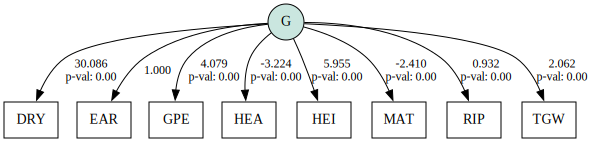

In [455]:
semopy.semplot(mod, "./model.png")

rmsea: <0.05
rmr: < 0.05
cfi: >0.95
tli: > 0.97
aic/BIC smaller is better

x2 / df < 2

In [456]:
semopy.calc_stats(mod)

DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline      CFI  \
Value   20            28  4.310908e+06           0.0   1.140141e+08  0.96219   

           GFI      AGFI      NFI       TLI     RMSEA        AIC        BIC  \
Value  0.96219  0.947066  0.96219  0.947066  12.68756 -47.156812  36.049987   

          LogLik  
Value  39.578406

In [457]:
fitdel = mod.predict_factors(df)


ST1 = ST_1.values
ST = fitdel.G
#ST = (fitst.G/fitsc.ST).values

array([[1.        , 0.85327258],
       [0.85327258, 1.        ]])

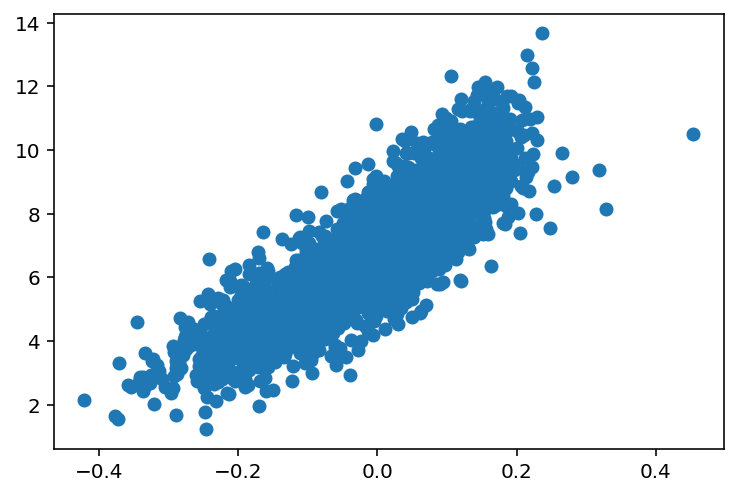

In [458]:

plt.scatter(ST, ST1);


np.corrcoef(ST, ST1)

In [439]:
# best fit so far
desc1 = \
''' ST =~ Growth + Yield 
    Yield =~ EAR + GPE + DRY + TGW
    Growth =~ HEA + MAT + RIP + HEI
    
'''

In [440]:
mod = semopy.Model(desc1)
res = mod.fit(dt_c.loc[:,2013,:], obj="ULS") #pd.concat([dt_t,dt_c]))
print(res)
print(mod.inspect())

# 1 Loading per factor is set to 1 for identification. 
# The other loadings are there in relative to this loading.

Name of objective: ULS
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 2698.840
Number of iterations: 178
Params: -0.260 4.062 44.612 2.017 0.748 -0.303 -1.856 1.943 23.270 19.798 81.837 2764.197 0.339 42.425 6.687 9.365 0.107 6.331
      lval  op    rval     Estimate    Std. Err    z-value   p-value
0   Growth   ~      ST     1.000000           -          -         -
1    Yield   ~      ST    -0.260024    0.024383  -10.66432       0.0
2      EAR   ~   Yield     1.000000           -          -         -
3      GPE   ~   Yield     4.062364    0.154023  26.375085       0.0
4      DRY   ~   Yield    44.611939    2.389255  18.671902       0.0
5      TGW   ~   Yield     2.017073    0.199517  10.109796       0.0
6      HEA   ~  Growth     1.000000           -          -         -
7      MAT   ~  Growth     0.748004    0.067787   11.03469       0.0
8      RIP   ~  Growth    -0.303066     0.03568  -8.494035       0.0
9      HEI   ~  Gro

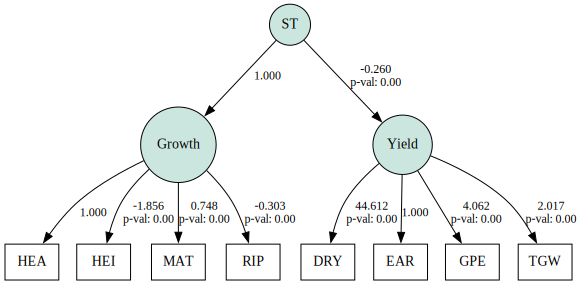

In [441]:
semopy.semplot(mod, "./model.png")

In [442]:
semopy.calc_stats(mod)

DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   18            28  3.616446e+06           0.0   1.140141e+08  0.968281   

            GFI      AGFI       NFI       TLI      RMSEA        AIC       BIC  \
Value  0.968281  0.950659  0.968281  0.950659  12.249359 -37.246869  56.36078   

          LogLik  
Value  36.623434

In [443]:
fitdel = mod.predict_factors(df)

ST1 = ST_1.values
ST = fitdel.ST
#ST = (fitst.G/fitsc.ST).values

array([[ 1.        , -0.27291879],
       [-0.27291879,  1.        ]])

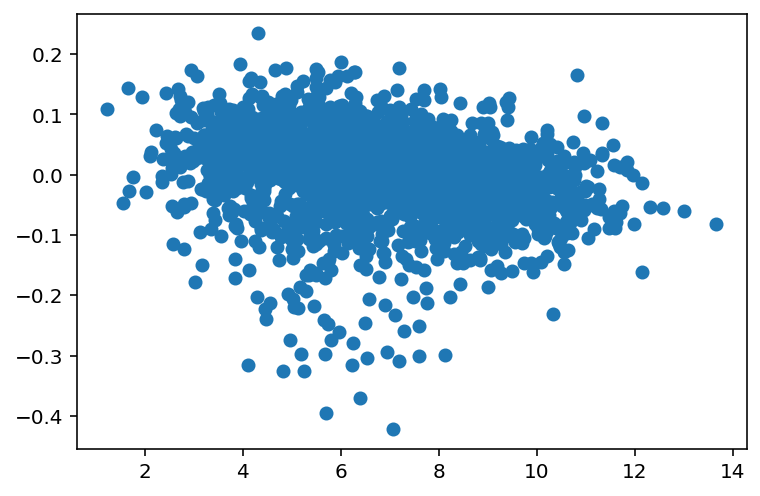

In [444]:
plt.scatter(ST1, ST);


np.corrcoef(ST1, ST)